In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
batch_size = 128

In [4]:
# data load
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True,
                                             transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True,
                                            transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
labels = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck")

In [6]:
print(train_dataset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [7]:
print(test_dataset)

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [8]:
print(f"Type of first element in tuple: {type(train_dataset[0][0])}. Type of second element in tuple: {type(train_dataset[0][1])}")

Type of first element in tuple: <class 'torch.Tensor'>. Type of second element in tuple: <class 'int'>


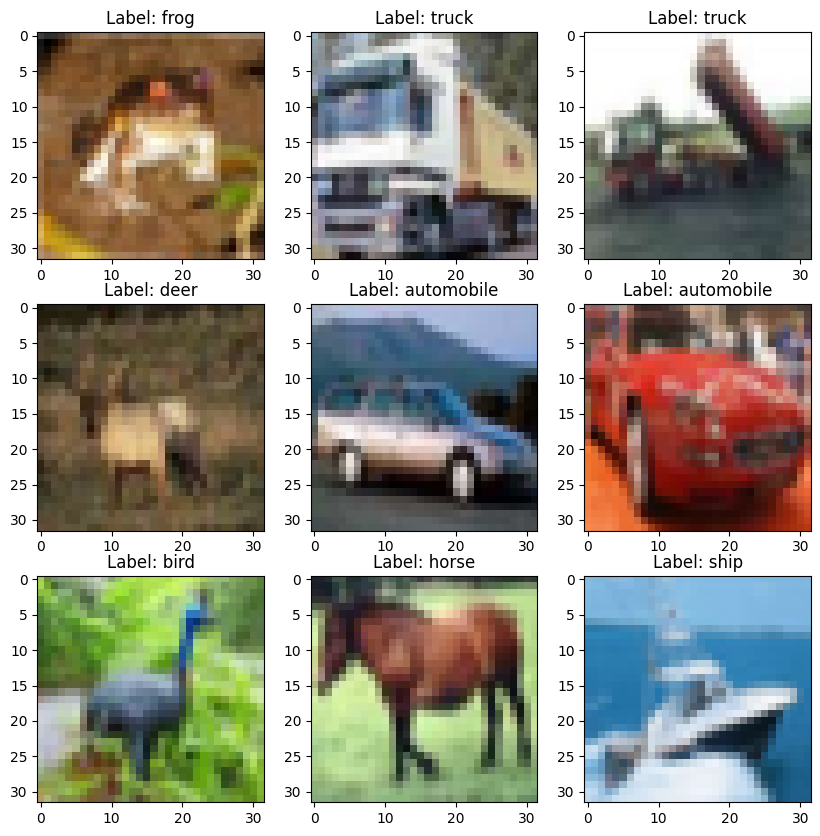

In [9]:
# image demonstration
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(np.transpose(train_dataset[i][0], (1, 2, 0)), cmap='gray')
    ax.set_title(f"Label: {labels[train_dataset[i][1]]}")
plt.show()

In [10]:
def make_cnn_layer(in_channels, out_channels):
  return nn.Sequential(nn.Conv2d(in_channels=in_channels,
                                 out_channels=out_channels,
                                 kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU()
                      )

In [11]:
class VGG19(nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        # 1st block
        self.conv1 = make_cnn_layer(3, 64)
        self.conv2 = make_cnn_layer(64, 64)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # 2nd block
        self.conv3 = make_cnn_layer(64, 128)
        self.conv4 = make_cnn_layer(128, 128)

        # 3rd block
        self.conv5 = make_cnn_layer(128, 256)
        self.conv6 = make_cnn_layer(256, 256)
        self.conv7 = make_cnn_layer(256, 256)
        self.conv8 = make_cnn_layer(256, 256)

        # 4th block
        self.conv9 = make_cnn_layer(256, 512)
        self.conv10 = make_cnn_layer(512, 512)
        self.conv11 = make_cnn_layer(512, 512)
        self.conv12 = make_cnn_layer(512, 512)

        # 5th block
        self.conv13 = make_cnn_layer(512, 512)
        self.conv14 = make_cnn_layer(512, 512)
        self.conv15 = make_cnn_layer(512, 512)
        self.conv16 = make_cnn_layer(512, 512)

        self.out = nn.Sequential(nn.Linear(1*1*512, 4096),
                                 nn.ReLU(),
                                 nn.Dropout(),
                                 nn.Linear(4096, 4096),
                                 nn.ReLU(),
                                 nn.Dropout(),
                                 nn.Linear(4096, 10))

    def forward(self, x):
        # 1st block
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.max_pool(x)

        # 2nd block
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.max_pool(x)

        # 3rd block
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.max_pool(x)

        # 4th block
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.conv11(x)
        x = self.conv12(x)
        x = self.max_pool(x)

        # 5th block
        x = self.conv13(x)
        x = self.conv14(x)
        x = self.conv15(x)
        x = self.conv16(x)
        x = self.max_pool(x)

        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output

In [12]:
def get_loss(pred, y_batch):
  return F.cross_entropy(pred, y_batch).mean()

In [13]:
def get_accuracy(pred, y_batch) -> float:
  pred = torch.argmax(pred, dim=1)
  return (pred == y_batch).sum().item() / float(y_batch.size(0))

In [14]:
class Remember:
  def __init__(self):
    self.train_loss = []
    self.test_loss = []
    self.train_accuracy = []
    self.test_accuracy = []

  def reset(self):
    self.train_loss = []
    self.test_loss = []
    self.train_accuracy = []
    self.test_accuracy = []

In [15]:
remember = Remember()

In [16]:
def fit(model, train_loader, test_loader, optimizer, num_epochs=None):
    import time
    train_losses = []
    test_losses = []
    train_accuracy_list = []
    test_accuracy_list = []

    min_loss = 1e6
    min_loss_index = 0
    epoch = 0

    # train loop
    while num_epochs is None or epoch < num_epochs:
        start_time = time.time()
        # train
        model.train()
        for X_batch, y_batch in train_loader:
            pred = model(X_batch.to(device))
            loss = get_loss(pred, y_batch.to(device))
            accuracy = get_accuracy(pred, y_batch.to(device))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.cpu().data.numpy())
            train_accuracy_list.append(accuracy)

        # test
        model.eval()
        for X_test_batch, y_test_batch in test_loader:
            with torch.no_grad():
                pred = model(X_test_batch.to(device))
                loss = get_loss(pred, y_test_batch.to(device))
                accuracy = get_accuracy(pred, y_test_batch.to(device))

                test_losses.append(loss.cpu().data.numpy())
                test_accuracy_list.append(accuracy)

        train_loss = np.mean(train_losses)
        test_loss = np.mean(test_losses)
        train_accuracy = np.mean(train_accuracy_list)
        test_accuracy = np.mean(test_accuracy_list)

        train_losses.clear()
        test_losses.clear()
        train_accuracy_list.clear()
        test_accuracy_list.clear()

        remember.train_loss.append(train_loss)
        remember.test_loss.append(test_loss)
        remember.train_accuracy.append(train_accuracy)
        remember.test_accuracy.append(test_accuracy)

        print("\nEpoch {} took {:.3f}s".format(epoch + 1, time.time() - start_time))
        print("training loss: \t{:.6f}".format(train_loss))
        print("test loss: \t{:.6f}".format(test_loss))
        print("train accuracy: \t{:.6f}".format(train_accuracy))
        print("test accuracy: \t{:.6f}".format(test_accuracy))

        # early stopping
        if test_loss < min_loss - 1e-5:
            min_loss = test_loss
            min_loss_index = epoch
        elif epoch - min_loss_index >= 7:
            break

        epoch += 1

In [17]:
model = VGG19()
model = model.to(device)

In [18]:
lr = 0.001
num_epochs = 25
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
remember.reset()
fit(model, train_loader, test_loader, optimizer, num_epochs)


Epoch 1 took 37.893s
training loss: 	1.990991
test loss: 	1.882156
train accuracy: 	0.199085
test accuracy: 	0.246737

Epoch 2 took 35.291s
training loss: 	1.653232
test loss: 	2.302515
train accuracy: 	0.327977
test accuracy: 	0.207377

Epoch 3 took 36.170s
training loss: 	1.448954
test loss: 	1.548431
train accuracy: 	0.410710
test accuracy: 	0.424941

Epoch 4 took 35.443s
training loss: 	1.258808
test loss: 	1.171123
train accuracy: 	0.520584
test accuracy: 	0.568829

Epoch 5 took 35.403s
training loss: 	1.052512
test loss: 	1.018052
train accuracy: 	0.619254
test accuracy: 	0.631032

Epoch 6 took 35.481s
training loss: 	0.917370
test loss: 	1.008946
train accuracy: 	0.676870
test accuracy: 	0.639834

Epoch 7 took 35.647s
training loss: 	0.798101
test loss: 	0.981149
train accuracy: 	0.725779
test accuracy: 	0.679688

Epoch 8 took 35.517s
training loss: 	0.703420
test loss: 	0.966955
train accuracy: 	0.762444
test accuracy: 	0.673358

Epoch 9 took 35.135s
training loss: 	0.626007
t

In [19]:
def draw_losses_plot(train_loss, test_loss):
    epochs = range(1, 1 + len(train_loss))

    fig, ax = plt.subplots(1,1, figsize=(10, 8))
    ax.set_title('Train and test loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.plot(epochs, train_loss, 'b--', label = "Train loss")
    ax.plot(epochs, test_loss, c='red', label = "Test loss")
    ax.legend()

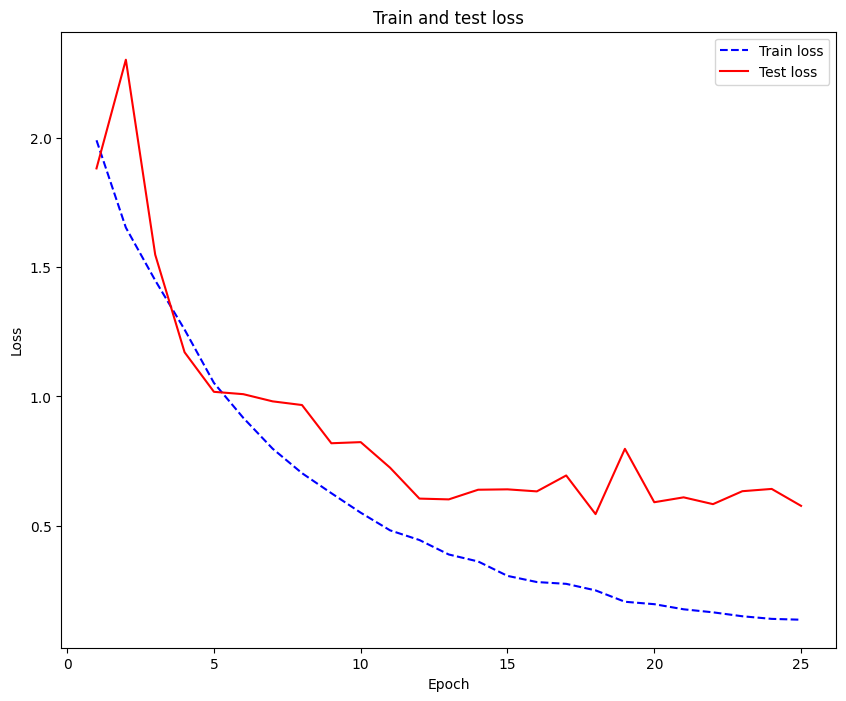

In [20]:
draw_losses_plot(remember.train_loss, remember.test_loss)

In [21]:
def draw_accuray_plot(train_accuracy, test_accuracy):
    epochs = range(1, 1 + len(train_accuracy))

    fig, ax = plt.subplots(1,1, figsize=(10, 8))
    ax.set_title('Train and test accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.plot(epochs, train_accuracy, 'b--', label = "Train accuracy")
    ax.plot(epochs, test_accuracy, c='red', label = "Test accuracy")
    ax.legend()

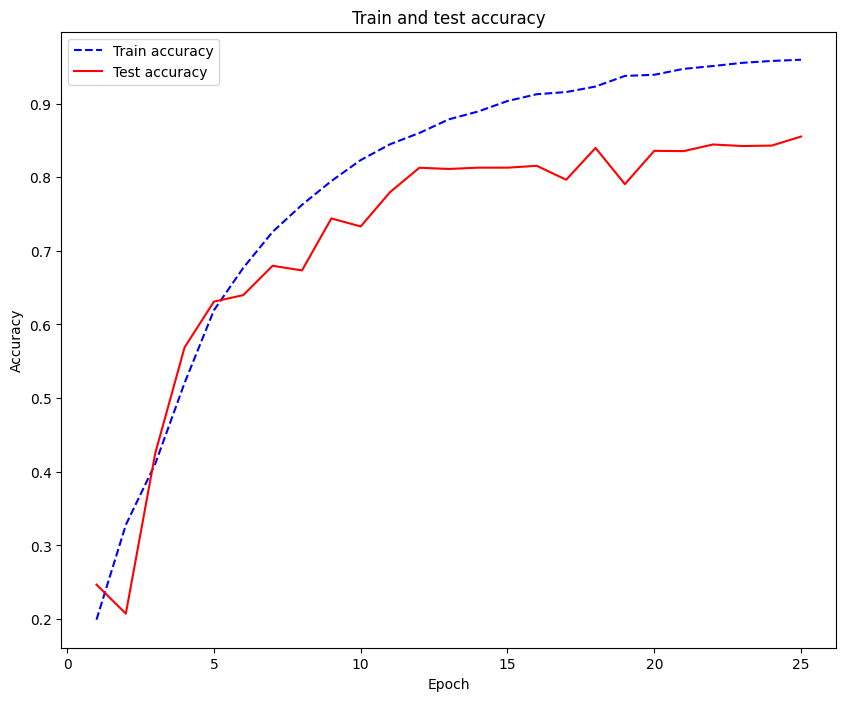

In [22]:
draw_accuray_plot(remember.train_accuracy, remember.test_accuracy)

In [23]:
accuracy_list = []
loss_list = []
model.eval()
for i, (X_test_batch, y_test_batch) in enumerate(test_loader):
    with torch.no_grad():
        pred = model(X_test_batch.to(device))
        accuracy = get_accuracy(pred, y_test_batch.to(device))
        loss = get_loss(pred, y_test_batch.to(device))

        accuracy_list.append(accuracy)
        loss_list.append(loss.item())

In [24]:
print("Test accuracy: {:.6f}".format(np.mean(accuracy_list)))
print("Test loss: {:.6f}".format(np.mean(loss_list)))

Test accuracy: 0.855123
Test loss: 0.577012
